In [1]:
%matplotlib inline

In [2]:
import yt

In [2]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

In [3]:
import utm
from mmctools.coupling.terrain import readSTL
from scipy.interpolate import RectBivariateSpline

In [29]:
sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper import addScalebar

In [5]:
def R(angleDeg):
    # Rotation matrix in a constant-z plane
    c, s = np.cos(np.deg2rad(angleDeg)), np.sin(np.deg2rad(angleDeg))
    return np.array(((c, -s, 0),(s, c, 0), (0, 0, 1)))


def computeRotatedBoxToCell(turb, wdir):
    '''
        Function that receives the wind direction, the turbine information (including
        the reference position), and the domain extents and determines the parameters
        that will go into the topoSetDict file for the rotatedBox type of refinement.
    '''
    
    ref = np.array((turb['xref'], turb['yref'], turb['zref']))
    refrot = np.matmul(R(-wdir),ref)

    xminbb = refrot[0] - turb['boxExtents_front']
    xmaxbb = refrot[0] + turb['boxExtents_back']

    yminbb = refrot[1] - turb['boxExtents_left']
    ymaxbb = refrot[1] + turb['boxExtents_right']

    zminbb = refrot[2] - turb['boxExtents_lower']
    zmaxbb = refrot[2] + turb['boxExtents_upper']
    
    # mininum and maximum x, y, z of the bounding box, before rotation
    #minxyzBB = np.array([ xminbb, yminbb, zminbb ])
    #maxxyzBB = np.array([ xmaxbb, ymaxbb, zmaxbb ])
    #lenBB = maxxyzBB - minxyzBB
    
    # Set the 8 vertices of the bounding box for convenience
    #                v[7]           v[6]
    #                 +-------------+
    #                /|            /|
    #               / |v[4]       / |
    #              /  +-------------+ v[5] 
    #             /  /          /  /
    #        v[3]+-------------+  / 
    #            | /           | /
    #    z       |/            |/
    #    ^       +-------------+
    #    | y   v[0]           v[1]
    #    |/
    #    +----> x
    vbb= np.zeros((8,3))
    vbb[0] = [xminbb, yminbb, zminbb]
    vbb[1] = [xmaxbb, yminbb, zminbb]
    vbb[2] = [xmaxbb, yminbb, zmaxbb]
    vbb[3] = [xminbb, yminbb, zmaxbb]
    vbb[4] = [xminbb, ymaxbb, zminbb]
    vbb[5] = [xmaxbb, ymaxbb, zminbb]
    vbb[6] = [xmaxbb, ymaxbb, zmaxbb]
    vbb[7] = [xminbb, ymaxbb, zmaxbb]

    # Rotate back into the rotated local space.
    for i in range(8):
        vbb[i] = np.matmul(R(wdir),vbb[i])
        
    # Get the origin vertex of the rotated box.
    origin = vbb[0] 
    # Get the i, j, k vectors that define the box lengths off of the origin.
    iVec = vbb[1] - vbb[0]
    jVec = vbb[4] - vbb[0]
    kVec = vbb[3] - vbb[0]
    
    return origin,iVec,jVec,kVec,vbb


def computeCylinderToCell(turb, wdir, axis='x'):
    '''
        Function that receives the wind direction, the turbine information (including
        the reference position), and the domain extents and determines the parameters
        that will go into the topoSetDict file for the `cylinder` type of refinement.
    '''

    ref = np.array((turb['xref'], turb['yref'], turb['zref']))
    refrot = np.matmul(R(-wdir),ref)

    if (axis == 'y'):
        p0 = [ refrot[0],    refrot[1] - turb['cylExtents_front'],    refrot[2] ]
        p1 = [ refrot[0],    refrot[1] + turb['cylExtents_back'],     refrot[2] ]
        #l = p1[1] - p0[1]
    elif (axis == 'z'):
        p0 = [ refrot[0],  refrot[1],   refrot[2] - turb['cylExtents_front']  ]
        p1 = [ refrot[0],  refrot[1],   refrot[2] + turb['cylExtents_back']   ]
        #l = p1[2] - p0[2]
    else:
        p0 = [ refrot[0] - turb['cylExtents_front'],   refrot[1],   refrot[2] ]
        p1 = [ refrot[0] + turb['cylExtents_back'],    refrot[1],   refrot[2] ]
        #l = np.abs(p1[0] - p0[0])
    
     
    radius = turb['cylExtents_radius']

    # Compute the volume of this cylinder.
    # vol = np.pi * radius**2 * l

    # Rotate back into the rotated local space.
    p0 = np.matmul(R(wdir),p0)
    p1 = np.matmul(R(wdir),p1)

    return p0, p1, radius


In [6]:
# Open the topoSet dictionary.
def openTopoSetDict(filename, refType, refExtent, referenceTerrain, terrain=True):
    fid = open(filename,'w')
    fid.write('/*--------------------------------*- C++ -*----------------------------------*\\ \n')
    fid.write('| =========                 |                                                 | \n')
    fid.write('| \\\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    fid.write('|  \\\\    /   O peration     | Website:  https://openfoam.org                  | \n')
    fid.write('|   \\\\  /    A nd           | Version:  6                                     | \n')
    fid.write('|    \\\\/     M anipulation  |                                                 | \n')
    fid.write('\*---------------------------------------------------------------------------*/ \n')
    fid.write('FoamFile \n')
    fid.write('{ \n')
    fid.write('    version     2.0; \n')
    fid.write('    format      ascii; \n')
    fid.write('    class       dictionary; \n')
    fid.write('    location    "system"; \n')
    if terrain:
        fid.write('    object      topoSetDict.biglowturbines.1; \n')
    else:
        fid.write('    object      topoSetDict.biglowturbines.flat.1; \n')
    fid.write('} \n')
    fid.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * // \n\n')
    if refType=='rotatedBox':
        fid.write(f'// rotatedBox refinement type. Box extents for all refinements in this file are: \n')
        fid.write(f'//  - upstream/front:   {refExtent[0]:.2f} D \n')
        fid.write(f'//  - downstream/back:  {refExtent[1]:.2f} D \n')
        fid.write(f'//  - left:             {refExtent[2]:.2f} D \n')
        fid.write(f'//  - right:            {refExtent[3]:.2f} D \n')
        fid.write(f'//  - lower:            {refExtent[4]:.2f} hub heights \n')
        fid.write(f'//  - upper:            {refExtent[5]:.2f} D \n\n')
    elif refType=='cylinder':
        fid.write(f'// cylinder refinement type. Box extents for all refinements in this file are: \n')
        fid.write(f'//  - upstream/front:   {refExtent[0]:.2f} D \n')
        fid.write(f'//  - downstream/back:  {refExtent[1]:.2f} D \n')
        fid.write(f'//  - radius:           {refExtent[2]:.2f} D \n\n')
    if terrain:
        fid.write(f'// Locations related to STL:\n//    {referenceTerrain}\n\n')
    else:
        fid.write(f'// Locations related to flat terrain. All bases at z=0. \n')
        fid.write(f'// To be executed in parallel with a terrain case that comes from the following STL file:\n')
        fid.write(f'// {referenceTerrain}\n\n')
    fid.write('actions \n')
    fid.write('( \n\n')
    return fid

    
# Close the topoSet dictionary.
def closeTopoSetDict(fid):
    fid.write('); \n')
    fid.write(' \n')
    fid.write('// ************************************************************************* //')
    fid.close()
    

# Close the topoSet dictionary.
def writeRotatedBoxToCell(fid,actionType,o,i,j,k, terrain=True):
    fid.write('\n    { \n')
    fid.write('        name         local.turbines; \n')
    fid.write('        type         cellSet; \n')
    fid.write(f'        action       {actionType}; \n')
    fid.write('        source       rotatedBoxToCell; \n')
    if terrain:
        fid.write(f"        // turbine T{row['t']}, USWTDB ID {row['case_id']}, model {row['t_model']}, base located at ({row['xref']:.2f}, {row['yref']:2f}, {row['zref']:2f}) \n")
    else:
        fid.write(f"        // turbine T{row['t']}, USWTDB ID {row['case_id']}, model {row['t_model']}, base located at ({row['xref']:.2f}, {row['yref']:2f}, 0) \n") 
    fid.write('        sourceInfo \n')
    fid.write('        { \n')
    fid.write(f'            origin ( {o[0]} {o[1]} {o[2]} ); \n')
    fid.write(f'            i      ( {i[0]} {i[1]} {i[2]} ); \n')
    fid.write(f'            j      ( {j[0]} {j[1]} {j[2]} ); \n')
    fid.write(f'            k      ( {k[0]} {k[1]} {k[2]} ); \n')
    fid.write('        } \n')  
    fid.write('    } \n')
    

# Close the topoSet dictionary.
def writeCylinderToCell(fid,actionType,p1,p2,r, terrain=True):
    fid.write('\n    { \n')
    fid.write('        name         local.turbines; \n')
    fid.write('        type         cellSet; \n')
    fid.write(f'        action       {actionType}; \n')
    fid.write('        source       cylinderToCell; \n')
    if terrain:
        fid.write(f"        // turbine T{row['t']}, USWTDB ID {row['case_id']}, model {row['t_model']}, base located at ({row['xref']:.2f}, {row['yref']:2f}, {row['zref']:2f}) \n")
    else:
        fid.write(f"        // turbine T{row['t']}, USWTDB ID {row['case_id']}, model {row['t_model']}, base located at ({row['xref']:.2f}, {row['yref']:2f}, 0) \n")
    fid.write('        sourceInfo \n')
    fid.write('        { \n')
    fid.write(f'            p1 ( {p1[0]} {p1[1]} {p1[2]} ); \n')
    fid.write(f'            p2 ( {p2[0]} {p2[1]} {p2[2]} ); \n')
    fid.write(f'            radius {r}; \n')
    fid.write('        } \n')  
    fid.write('    } \n')

In [7]:
def vbbForPlotting (vbb, dim='2d'):
    '''
        Get vertices of the bounding box (vbb) from computeRotatedBoxToCell
        function and put into a format for plotting using `Polygon`
    '''
    if dim=='2d':
        # get points on zmin plane and repeat the last one for plotting
        vbb2d = vbb[[0,1,5,4],:-1]
        vbb2d = np.vstack([vbb2d,vbb2d[0]])
        return vbb2d
    elif dim=='3d':
        vbb3d = np.vstack([vbb,vbb[0]])
        return vbb3d
    else:
         raise ValueError('Dimension is not valid') 
            
            
def cylbbForPlotting (p0,p1,r,wdir, dim='2d'):
    '''
        Get end points and radius of the cylinder from computeCylinderToCell
        functionand put into a format for plotting using `Polygon`.
    '''
    if dim=='2d':
        c, s = np.cos(np.deg2rad(wdir)), np.sin(np.deg2rad(wdir))
        # get points on zmin plane and repeat the last one for plotting
        vbb2d = [ [p0[0]-s*r, p0[1]+c*r],
                  [p1[0]-s*r, p1[1]+c*r],
                  [p1[0]+s*r, p1[1]-c*r],
                  [p0[0]+s*r, p0[1]-c*r] ]
        vbb2d = np.vstack([vbb2d,vbb2d[0]])
        return vbb2d
    elif dim=='3d':
        raise NotImplementedError('Plotting for 3D cylinder is not available.')
    else:
        raise ValueError('Dimension is not valid') 

# Preprocessing of turbine refinement regions and virtual masts

This notebook takes information from the USWTDB and generate input files for SOWFA with the approapriate coordinates. Includes complex terrain.

Regis Thedin \
Nov 2021

# 1. Get turbine data

## 1.1. Load up USWTDB turbines

Following instructions from `https://code.usgs.gov/cdi/cdi-fy20/jupyter-data-stories/-/blob/main/examples/wind_turbine/uswtdbApiMapVizExamples.ipynb`

In [8]:
# Call the USWTDB API and apply custom URL parameters to the request. Parameters allow us to filter the data return.
data_url = "https://eersc.usgs.gov/api/uswtdb/v1/turbines?&t_cap=gt.0&select=case_id,t_state,t_county,p_name,t_manu,t_model,t_cap,t_hh,t_rd,xlong,ylat"

# Parse the JSON response from the API return and populate the dataframe
df = pd.read_json(data_url)

In [9]:
# Specify all the farms in the general area of interest. Later on section 1.3. the actual turbines of interest will be selected from the larger dataframe
# It is safer to specify the state so we don't end up with turbines from a farm with the same name somewhere else.

biglow1    = df.loc[(df['p_name']=='Biglow Canyon I')   & (df['t_state']=='OR')]
biglow2    = df.loc[(df['p_name']=='Biglow Canyon II')  & (df['t_state']=='OR')]
biglow3    = df.loc[(df['p_name']=='Biglow Canyon III') & (df['t_state']=='OR')]
klondike1  = df.loc[(df['p_name']=='Klondike I')        & (df['t_state']=='OR')]
klondike2  = df.loc[(df['p_name']=='Klondike II')       & (df['t_state']=='OR')]
klondike3  = df.loc[(df['p_name']=='Klondike III')      & (df['t_state']=='OR')]
klondike3a = df.loc[(df['p_name']=='Klondike IIIA')     & (df['t_state']=='OR')]
patu       = df.loc[(df['p_name']=='PaTu Wind Farm')    & (df['t_state']=='OR')]
hay        = df.loc[(df['p_name']=='Hay Canyon')        & (df['t_state']=='OR')]
starpoint  = df.loc[(df['p_name']=='Star Point')        & (df['t_state']=='OR')]

turb = pd.concat([biglow1, biglow2, biglow3, klondike1, klondike2, klondike3, klondike3a, patu, hay, starpoint])

# Reorder by case_id so it is always consistent. Within that, group all turbines of the same time together
turb = turb.sort_values(['t_model','case_id'], ascending=[False,True])

## 1.2. Set `x` and `y` reference on all turbines selected

In [10]:
referenceTerrain = '/home/rthedin/stl/wfip_xm15015to15735_ym15015to13815_ds30.0_SRTMblendToWRF_3N3S3E3W_noShift_setBlockMeshzMinTo379.stl'

xxstl, yystl, zstl = readSTL(referenceTerrain, stlres=30)

# limits of the CFD domain. The limits of the STL file are res/2 larger on each side. This is only used for plotting.
xminCFD = -15000
xmaxCFD = 15720
yminCFD = -15000
ymaxCFD = 13800

In [11]:
# This reference should be the same as the one in the STL-generating notebook, as well as in the WRF-boundary notebook 
refloc = (45.638004, -120.642973) # biglow PS12 met mast; physics site

In [12]:
# Get reference location in UTM [m]
xref,yref,_,_ = utm.from_latlon(refloc[0], refloc[1])

# Add x and y, coordinates in UTM [m]
turb['x'] = turb.apply(lambda turb: utm.from_latlon(turb['ylat'], turb['xlong'])[0], axis=1)
turb['y'] = turb.apply(lambda turb: utm.from_latlon(turb['ylat'], turb['xlong'])[1], axis=1)

# Define a new reference system that is aligned with the STL and thus with SOWFA
turb['xref'] = turb['x']-xref
turb['yref'] = turb['y']-yref

## 1.3. Set turbines of interest

Usually we are only interested in including a subset of turbines into the simulation, be it by `turbineArrayProperties` or by sampling virtual masts

In [13]:
# Getting only the Biglow wind farms
turbsOI = turb.loc[turb['p_name'].str.startswith('Biglow')].copy()

# Numering turbines starting at 1 for convenience. This numbering will be referenced many times. It is simpler than the id that comes from USWTDB
turbsOI['t'] = np.arange(len(turbsOI))+1

## 1.4. Set height reference on the turbines of interest

In [14]:
f = RectBivariateSpline(xxstl[:,0], yystl[0,:], zstl)
turbsOI['zref'] = f(turbsOI.xref.values, turbsOI.yref.values, grid=False)

# 2. Generate SOWFA input files

In [15]:
#targetDir = '/projects/mmc/rthedin/OpenFOAM/rthedin-6/run/mmc_biglow/21_biglowTurb/system'
targetDir = '/projects/osw/rthedin/OpenFOAM/rthedin-6/run/mmc_biglow_v82/22_biglow_test_V82/system'
targetDir = '/projects/osw/rthedin/OpenFOAM/rthedin-6/run/mmc_biglow_v82/31_biglow_wholeFarm_2localRef_withg/system'
if not os.path.exists(targetDir):
    raise ValueError('Vefiry that the target case directory exists')

## 2.1. `turbineArrayProperties`

Generates contents of `turbineArrayProperties` for copy/paste only

In [ ]:
# for copy/paste
for i, (t, row) in enumerate(turbsOI.iterrows()):
    print(f'T{i+1}    // USWTDB {row.p_name} turbine ID number {row.case_id}')
    print('{')
    print(f'    turbineType                      "{row.t_model}";')
    print(f'    FASTInputFileName                "{row.t_model}.T{i+1}.fst";')
    print(f'    FASTRestartFileName              "{row.t_model}.T{i+1}.chkpt";')
    print(f'    baseLocation                     ({row.xref} {row.yref} {row.zref});')
    print(f'    #include "turbineDefaults"')
    print('}\n')

## 2.2. Virtual masts sampling file
Saves inside `~/stl/vmasts*`

In [16]:
# Set the heights of the virtual masts
vheights = np.concatenate((np.arange(5,200,5), np.arange(200,3000,50)))
pert = 0.001

In [17]:
# Get casename from the STL name
case = os.path.splitext(os.path.basename(referenceTerrain))[0]

### 2.2.1. For complex terrain cases
Print virtual masts coordinate files starting with AGL height

In [18]:
tpath = f'/projects/osw/rthedin/stl/turbinevmasts_{case}'
if not os.path.exists(tpath):
    os.makedirs(tpath)

In [20]:
for i, (t, row) in enumerate(turbsOI.iterrows()):
    print(f'Saving files {i+1}/{len(turbsOI)}    ', end='\r')
    
    fid = open(os.path.join(tpath,f'vmast_turbine{i+1}.txt'), 'w')
    fid.write(f"// Coordinates of virtual mast of {row['p_name']} USWTDB turbine id number {row['case_id']}, with AGL height of {row['zref']}, related to the following STL file:\n")
    fid.write(f'// {referenceTerrain}\n\n')
    for h in vheights:
        fid.write(f"( {row['xref']:.2f} {row['yref']:.2f} {row['zref']+h+pert:.3f} )\n")
    fid.close()

Generates contents of `system/sampling/vmasts_terrain` for copy/paste only

In [ ]:
# Print sampling file (for copy/paste)
for i, (t, row) in enumerate(turbsOI.iterrows()):
    print(f'mast_turbine{i+1}    // USWTDB {row.p_name} turbine ID number {row.case_id}')
    print('{')
    print('    type    points;')
    print('    ordered no;')
    print('    axis    xyz;')
    print('    points  (')
    path = os.path.join(tpath,'vmast_turbine'+str(i+1)+'.txt')
    print(f'        #include \"{path}\"')
    print('            );')
    print('}')

### 2.2.2. For flat-terrain cases

If interested in running the same case with flat domain and wants to save at the same spots. The difference here is that the height does not include the absolute terrain height at a certain location. Here, it print virtual masts coordinate files starting at $z=0$

In [20]:
fpath = f'/projects/mmc/rthedin/stl/turbinevmasts_{case}_flat'
if not os.path.exists(fpath):
    os.makedirs(fpath)

In [27]:
for i, (t, row) in enumerate(turbsOI.iterrows()):
    print(f'Saving files {i+1}/{len(turbsOI)}    ', end='\r')
    
    fid = open(os.path.join(fpath,f'vmast_turbine{i+1}_flat.txt'), 'w')
    fid.write(f"// Coordinates of virtual mast of {row['p_name']} USWTDB turbine id number {row['case_id']}, for a flat terrain case (only x and y matter here)\n")
    fid.write(f'// To be executed in parallel with a terrain case that comes from the following STL file:\n')
    fid.write(f'// {referenceTerrain}\n\n')
    for h in vheights:
        fid.write(f"( {row['xref']:.2f} {row['yref']:.2f} {h+pert:.3f} )\n")
    fid.close()

Generates contents of `system/sampling/vmasts_flat` for copy/paste only

In [ ]:
# Print sampling file (for copy/paste)
for i, (t, row) in enumerate(turbsOI.iterrows()):
    print(f'mast_turbine{i+1}    // USWTDB {row.p_name} turbine ID number {row.case_id}, masts designed for flat terrain')
    print('{')
    print('    type    points;')
    print('    ordered no;')
    print('    axis    xyz;')
    print('    points  (')
    path = os.path.join(fpath,'vmast_turbine'+str(i+1)+'_flat.txt')
    print(f'        #include \"{path}\"')
    print('            );')
    print('}')

## 2.3. `topoSet` regions around turbines

#### User-modifiable information about the refinement regions

Select the wind direction and the type of refinement desired. Pick one refinement at a time and execute the rest of the code. If a second refinement is desired, change `refType`, `wdir`, and `ref*ExtentInD` and re-run the rest of the code. If you have executed both `cylinder` and `rotatedBox` refinements, then the last image showing a zoon of a couple of turines might be useful. It is safe to ignore the extents of the unused refinement type.

In [19]:
# Wind direction
# The case 2016-11-21 has winds varying from about 250 to 290 over the whole diurnal cycle. Here I will generate 3 sets and just add them together
wDir = 255
wDir = 270
wDir = 285

# What type of refinement?  Options are `rotatedBox` and `cylinder`
refType = 'rotatedBox'
# How far should the box refiniment extend, in diameters (except `lower`)
refBoxExtentInD = [ 7,    # upstream/front
                    6,    # downstream/back
                    1.3,  # left
                    1.3,  # right   
                    1.2,  # lower, in hub heights 
                    2     # upper
                  ]      
# How far should the cylinder refiniment extend, in diameters
# This is a pretty tight refinement-- use when the surrounding grid is already ~10m
# refCylExtentInD = [ 0.2,      # upstream/front
#                     0.2,      # downstream/back
#                     1.5*0.5   # radius
#                   ]
# This is a not-so-tight refinement. To use on relatively coarse grid to bring the local grid to 10m
refCylExtentInD = [ 2,        # upstream/front
                    2,        # downstream/back
                    1.8*0.5   # radius
                  ]     

# Write topoSet files for the refinement type selected above?
writeFiles=False
# Should the files contain the different elevations for the terrain? Run twice if both with and without terrain are needed.
terrain=True

In [20]:
# Add refinementType
turbsOI['refinementType'] = refType

# Add action of 'new' cellSet on the first turbine of each refinement type, and 'add' to the rest
turbsOI['action'] = 'add';  turbsOI.iloc[(0), turbsOI.columns.get_loc('action') ] = 'new'

# If selected `rotatedBox`, give the desired box refinement region extents
turbsOI['boxExtents_front'] =  refBoxExtentInD[0]*turbsOI['t_rd']   # front
turbsOI['boxExtents_back' ] =  refBoxExtentInD[1]*turbsOI['t_rd']   # back
turbsOI['boxExtents_left' ] =  refBoxExtentInD[2]*turbsOI['t_rd']   # left
turbsOI['boxExtents_right'] =  refBoxExtentInD[3]*turbsOI['t_rd']   # right
turbsOI['boxExtents_lower'] =  refBoxExtentInD[4]*turbsOI['t_hh']   # lower
turbsOI['boxExtents_upper'] =  refBoxExtentInD[5]*turbsOI['t_rd']   # upper

# If selected `cylinder`, give the desired cylinder refinement region extents (a second cylinder-type refinement recommended for ALM)
turbsOI['cylExtents_front'] =  refCylExtentInD[0]*turbsOI['t_rd']   # front
turbsOI['cylExtents_back' ] =  refCylExtentInD[1]*turbsOI['t_rd']   # back
turbsOI['cylExtents_radius']=  refCylExtentInD[2]*turbsOI['t_rd']   # radius

#### Compute `topoSet` regions

In [21]:
# Adjust wind direction convention
wdir= 270-wDir

# Initialize cumulative variables
if refType == 'rotatedBox':
    all_o = [];     all_vbb = []
    all_ivec = [];  all_jvec = [];  all_kvec = []
    refExtent = refBoxExtentInD # Just for printing info on file
elif refType == 'cylinder':
    all_p1 = [];    all_p2 = [];    all_r = []
    refExtent = refCylExtentInD # Just for printing info on file
else:
    raise ValueError (f'Refinement type refType {refType} is not valid')

if terrain:
    filename = os.path.join(targetDir,f"topoSetDict.biglowturbines.wdir{wDir}.{refType}")
else:
    filename = os.path.join(targetDir,f"topoSetDict.biglowturbines.flat.wdir{wDir}.{refType}")
    
if writeFiles:  fid = openTopoSetDict(filename, refType, refExtent, referenceTerrain=referenceTerrain, terrain=terrain)
        
for i, (_, row) in enumerate(turbsOI.iterrows()):
        
    if row['refinementType'] == 'rotatedBox':
        o,ivec,jvec,kvec,vbb = computeRotatedBoxToCell(row,wdir)
        all_o.append(o);        all_vbb.append(vbb)
        all_ivec.append(ivec);  all_jvec.append(jvec);   all_kvec.append(kvec)
        if writeFiles:  writeRotatedBoxToCell(fid,row['action'],o,ivec,jvec,kvec,terrain=terrain)
            
    elif row['refinementType'] == 'cylinder':
        p1,p2,r = computeCylinderToCell(row,wdir)
        all_p1.append(p1);  all_p2.append(p2);  all_r.append(r)
        if writeFiles:  writeCylinderToCell(fid,row['action'],p1,p2,r,terrain=terrain)

if writeFiles:  closeTopoSetDict(fid)

# Add refinement specs to main dataframe as lists for plotting purposes
if refType == 'rotatedBox':
    turbsOI['o']    = all_o;     turbsOI['vbb']  = all_vbb
    turbsOI['ivec'] = all_ivec;  turbsOI['jvec'] = all_jvec;  turbsOI['kvec'] = all_kvec
elif refType == 'cylinder':
    turbsOI['p1'] = all_p1;  turbsOI['p2'] = all_p2; turbsOI['r'] = all_r
    

# 4. Visualization

In [22]:
# Add some settings for plotting
turbsOI.loc[(turbsOI['t_model']=='V82-1.65'),  'plt_shadingcolor'] = 'orange'
turbsOI.loc[(turbsOI['t_model']=='SWT-2.3-93'),'plt_shadingcolor'] = 'coral'
turbsOI.loc[(turbsOI['t_model']=='V82-1.65'),  'plt_markercolor'] = 'darkorange'
turbsOI.loc[(turbsOI['t_model']=='SWT-2.3-93'),'plt_markercolor'] = 'red'
turbsOI.loc[(turbsOI['t_model']=='V82-1.65'),  'plt_marker'] = 'x'
turbsOI.loc[(turbsOI['t_model']=='SWT-2.3-93'),'plt_marker'] = '.'

#### Whole domain and nearby farms

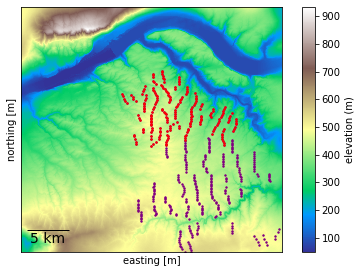

In [40]:
fig,ax = plt.subplots(figsize=(6,4.5))
cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='elevation (m)')

ax.scatter(turb['xref'], turb['yref'], c='purple', s=2)
ax.scatter(turbsOI['xref'], turbsOI['yref'], c='red', s=2)

domainbox = Rectangle((xminCFD,yminCFD), xmaxCFD-xminCFD, ymaxCFD-yminCFD, edgecolor='r', lw=3 , facecolor='none')
#ax.add_patch(domainbox)  # to add the red box around the CFD domain

addScalebar(ax, 5000, '5 km')

ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]')
ax.axis('scaled')
ax.set_xlim([xminCFD,xmaxCFD]);  ax.set_ylim([yminCFD,ymaxCFD])
plt.show()

fig.savefig('/scratch/rthedin/figForreadthedocs/wfip2_biglow_domain.png', bbox_inches='tight', dpi=150)

#### Refinement regions around the turbines of interest

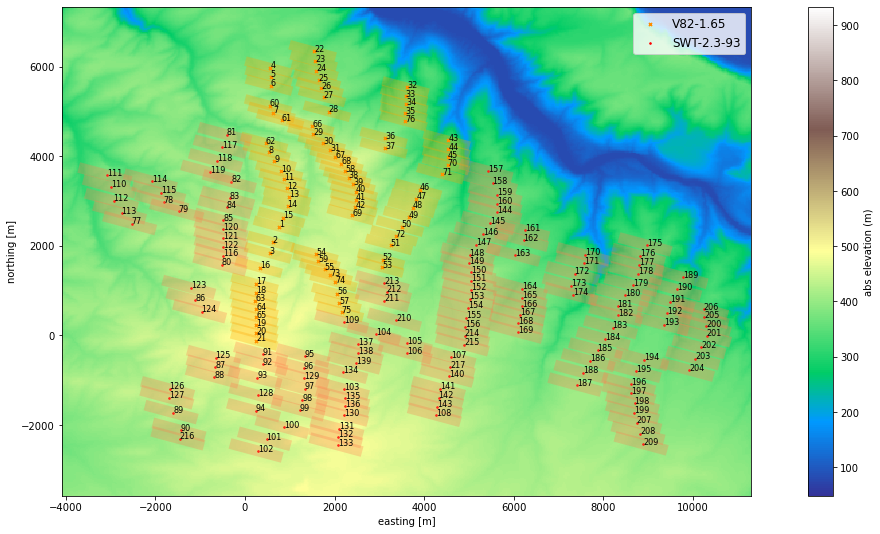

In [41]:
fig,ax = plt.subplots(figsize=(16,9))

# Show terrain
cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='abs elevation (m)')

# Show all turbines of interest, separated by turbine model
for t_model in turbsOI['t_model'].unique():
    marker = turbsOI.loc[turbsOI['t_model']==t_model].iloc[0]['plt_marker']
    markercolor = turbsOI.loc[turbsOI['t_model']==t_model].iloc[0]['plt_markercolor']
    xref = turbsOI.loc[turbsOI['t_model']==t_model]['xref']
    yref = turbsOI.loc[turbsOI['t_model']==t_model]['yref']
    sc = ax.scatter(xref, yref, c=markercolor, s=10, marker=marker, label=t_model)

# Loop over turbines to print additional information
for i, (_, row) in enumerate(turbsOI.iterrows()):
    # Show {i,j}vec vectors from origin
    #ax.quiver(row['o'][0], row['o'][1], row['ivec'][0], row['ivec'][1], units='xy', scale=1)
    #ax.quiver(row['o'][0], row['o'][1], row['jvec'][0], row['jvec'][1], units='xy', scale=1)
    
    # Show shaded bounding box of the refinement area
    if   row['refinementType'] == 'rotatedBox': bb = vbbForPlotting(row['vbb'])
    elif row['refinementType'] == 'cylinder':   bb = cylbbForPlotting(row['p1'],row['p2'],row['r'],wdir)
    p = Polygon(bb, facecolor = row['plt_shadingcolor'], alpha=0.3)
    ax.add_patch(p)
    
    # Show turbine number 
    ax.annotate(row['t'], (row['xref'], row['yref']), fontsize=8)


# domainbox = Rectangle((xminCFD,yminCFD), xmaxCFD-xminCFD, ymaxCFD-yminCFD, edgecolor='r', lw=3 , facecolor='none')
# ax.add_patch(domainbox)

plt.legend(loc='upper right', fontsize=12)

ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]'); ax.axis('scaled')
plotFringe = 1000
ax.set_xlim([min(turbsOI['xref'])-plotFringe,  max(turbsOI['xref'])+plotFringe])
ax.set_ylim([min(turbsOI['yref'])-plotFringe,  max(turbsOI['yref'])+plotFringe])

plt.show()


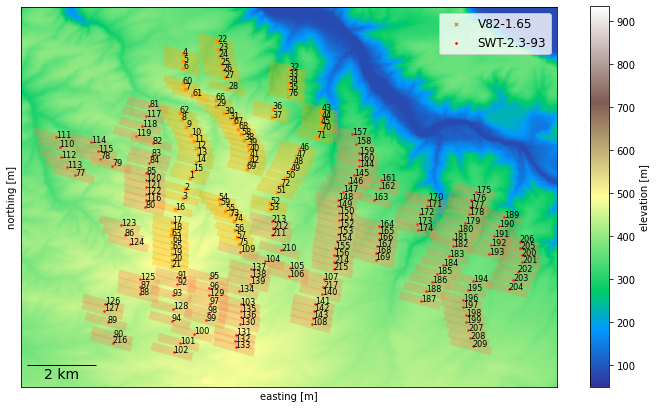

In [43]:
fig,ax = plt.subplots(figsize=(12,7))

# Show terrain
cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='elevation [m]')

# Show all turbines of interest, separated by turbine model
for t_model in turbsOI['t_model'].unique():
    marker = turbsOI.loc[turbsOI['t_model']==t_model].iloc[0]['plt_marker']
    markercolor = turbsOI.loc[turbsOI['t_model']==t_model].iloc[0]['plt_markercolor']
    xref = turbsOI.loc[turbsOI['t_model']==t_model]['xref']
    yref = turbsOI.loc[turbsOI['t_model']==t_model]['yref']
    sc = ax.scatter(xref, yref, c=markercolor, s=10, marker=marker, label=t_model)

# Loop over turbines to print additional information
for i, (_, row) in enumerate(turbsOI.iterrows()):
    # Show {i,j}vec vectors from origin
    #ax.quiver(row['o'][0], row['o'][1], row['ivec'][0], row['ivec'][1], units='xy', scale=1)
    #ax.quiver(row['o'][0], row['o'][1], row['jvec'][0], row['jvec'][1], units='xy', scale=1)
    
    # Show shaded bounding box of the refinement area
    if   row['refinementType'] == 'rotatedBox': bb = vbbForPlotting(row['vbb'])
    elif row['refinementType'] == 'cylinder':   bb = cylbbForPlotting(row['p1'],row['p2'],row['r'],wdir)
    p = Polygon(bb, facecolor = row['plt_shadingcolor'], alpha=0.3)
    ax.add_patch(p)
    
    # Show turbine number 
    ax.annotate(row['t'], (row['xref'], row['yref']), fontsize=8)


# domainbox = Rectangle((xminCFD,yminCFD), xmaxCFD-xminCFD, ymaxCFD-yminCFD, edgecolor='r', lw=3 , facecolor='none')
# ax.add_patch(domainbox)

plt.legend(loc='upper right', fontsize=12)

ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]'); ax.axis('scaled')
plotFringe = 1000
ax.set_xlim([min(turbsOI['xref'])-plotFringe,  max(turbsOI['xref'])+plotFringe])
ax.set_ylim([min(turbsOI['yref'])-plotFringe,  max(turbsOI['yref'])+plotFringe])

addScalebar(ax, 2000, '2 km')


plt.show()
fig.savefig('/scratch/rthedin/figForreadthedocs/wfip2_biglow_turbines.png', bbox_inches='tight', dpi=150)

#### Zoom on a nested refinement
Showing two arbitrary turbines. This plot will only make sense if you have small refinements and want to see up close. It also shows both `rotatedBox` and `cylinder`, so if you haven't executed the code with both refinement types, you will need to comment out some of the plotting.

This case is executed in `run/mmc_biglow/21_biglowTurb`

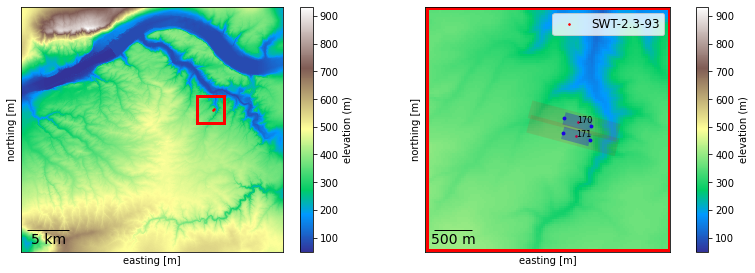

In [46]:
# figure for Matt for MMC report

zoomTurbs = turbsOI.loc[(turbsOI['t']==170) | (turbsOI['t']==171)].copy()



fig,axs = plt.subplots(ncols=2, figsize=(13,4.51))

for ax in axs:
    # Show terrain
    cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=ax, label='elevation (m)')

    # Show all turbines of interest, separated by turbine model
    for t_model in zoomTurbs['t_model'].unique():
        marker = zoomTurbs.loc[zoomTurbs['t_model']==t_model].iloc[0]['plt_marker']
        markercolor = zoomTurbs.loc[turbsOI['t_model']==t_model].iloc[0]['plt_markercolor']
        xref = zoomTurbs.loc[zoomTurbs['t_model']==t_model]['xref']
        yref = zoomTurbs.loc[zoomTurbs['t_model']==t_model]['yref']
        sc = ax.scatter(xref, yref, c=markercolor, s=10, marker=marker, label=t_model)


    ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]');  ax.axis('scaled')
    ax.set_xlim([min(zoomTurbs['xref'])-800,  max(zoomTurbs['xref'])+600])
    ax.set_ylim([min(zoomTurbs['yref'])-250,  max(zoomTurbs['yref'])+250])

    # 3x3 domain. 3200x3200 exactly to fit 640m grid
    xmin=5600
    xmax=8800
    ymin=100
    ymax=3300
    domain3x3box = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3 , facecolor='none')
    ax.add_patch(domain3x3box)

    
# Loop over turbines to print additional information
for i, (_, row) in enumerate(zoomTurbs.iterrows()):

    # Show cylinder refinement
    p0,p1,r = computeCylinderToCell(row, wdir)
    axs[1].scatter(p0[0], p0[1], s=8, c='blue')
    axs[1].scatter(p1[0], p1[1], s=8, c='blue')
    p = Polygon(cylbbForPlotting(p0,p1,r,wdir), facecolor = 'blue', alpha=0.3)
    axs[1].add_patch(p)

    # Show rotatedBox refinement
    o,ivec,jvec,kvec,vbb = computeRotatedBoxToCell(row,wdir)
    p = Polygon(vbbForPlotting(vbb), facecolor = 'red', alpha=0.1)
    axs[1].add_patch(p)

    # Show shaded refinement area
    #p = Polygon(vbbForPlotting(row['vbb']), facecolor = row['plt_shadingcolor'], alpha=0.3)#, label=row['t_model'] if i==0 else None)
    #ax.add_patch(p)

    # Show turbine number 
    axs[1].annotate(row['t'], (row['xref'], row['yref']), fontsize=8)


plt.legend(loc='upper right', fontsize=12)
    
addScalebar(axs[0], 5000, '5 km')
addScalebar(axs[1], 500, '500 m')

axs[0].set_xlim([xminCFD,xmaxCFD])
axs[0].set_ylim([yminCFD, ymaxCFD])

axs[1].set_xlim([xmin-20,  xmax+20])
axs[1].set_ylim([ymin-20,  ymax+20])

plt.show()


fig.savefig('/scratch/rthedin/figForreadthedocs/wfip2_biglow_2turbines.png', bbox_inches='tight', dpi=150)

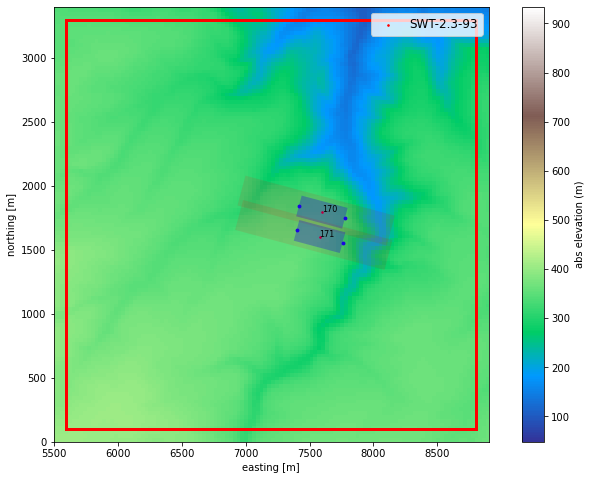

In [28]:
zoomTurbs = turbsOI.loc[(turbsOI['t']==170) | (turbsOI['t']==171)].copy()



fig,ax = plt.subplots(figsize=(10,8))

# Show terrain
cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='abs elevation (m)')

# Show all turbines of interest, separated by turbine model
for t_model in zoomTurbs['t_model'].unique():
    marker = zoomTurbs.loc[zoomTurbs['t_model']==t_model].iloc[0]['plt_marker']
    markercolor = zoomTurbs.loc[turbsOI['t_model']==t_model].iloc[0]['plt_markercolor']
    xref = zoomTurbs.loc[zoomTurbs['t_model']==t_model]['xref']
    yref = zoomTurbs.loc[zoomTurbs['t_model']==t_model]['yref']
    sc = ax.scatter(xref, yref, c=markercolor, s=10, marker=marker, label=t_model)

    
# Loop over turbines to print additional information
for i, (_, row) in enumerate(zoomTurbs.iterrows()):
    
    # Show cylinder refinement
    p0,p1,r = computeCylinderToCell(row, wdir)
    ax.scatter(p0[0], p0[1], s=8, c='blue')
    ax.scatter(p1[0], p1[1], s=8, c='blue')
    p = Polygon(cylbbForPlotting(p0,p1,r,wdir), facecolor = 'blue', alpha=0.3)
    ax.add_patch(p)
    
    # Show rotatedBox refinement
    o,ivec,jvec,kvec,vbb = computeRotatedBoxToCell(row,wdir)
    p = Polygon(vbbForPlotting(vbb), facecolor = 'red', alpha=0.1)
    ax.add_patch(p)

    # Show shaded refinement area
    #p = Polygon(vbbForPlotting(row['vbb']), facecolor = row['plt_shadingcolor'], alpha=0.3)#, label=row['t_model'] if i==0 else None)
    #ax.add_patch(p)
    
    # Show turbine number 
    ax.annotate(row['t'], (row['xref'], row['yref']), fontsize=8)


plt.legend(loc='upper right', fontsize=12)

ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]');  ax.axis('scaled')
ax.set_xlim([min(zoomTurbs['xref'])-800,  max(zoomTurbs['xref'])+600])
ax.set_ylim([min(zoomTurbs['yref'])-250,  max(zoomTurbs['yref'])+250])

# 3x3 domain. 3200x3200 exactly to fit 640m grid
xmin=5600
xmax=8800
ymin=100
ymax=3300
domain3x3box = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3 , facecolor='none')
ax.add_patch(domain3x3box)

ax.set_xlim([xmin-100,  xmax+100])
ax.set_ylim([ymin-100,  ymax+100])

plt.show()

## Zoom on two V82 turbines for OpenFAST V82 model testing

Following the same approach as the case above-- a small domain with a couple of turbines manually picked.

This case is executed in `run/mmc_biglow_v82/22_biglow_test_V82`. This terrain _looks_ very similar to the one right above zoomed on turbines 169 and 170, but it is not.

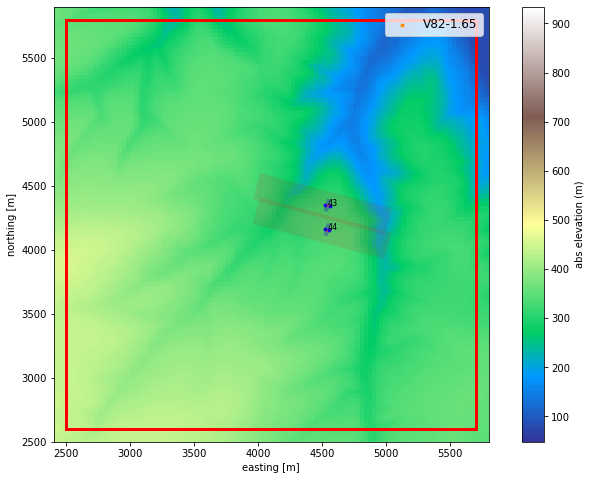

In [67]:
zoomTurbs = turbsOI.loc[(turbsOI['t']==43) | (turbsOI['t']==44)].copy()




fig,ax = plt.subplots(figsize=(10,8))

# Show terrain
cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='abs elevation (m)')

# Show all turbines of interest, separated by turbine model
for t_model in zoomTurbs['t_model'].unique():
    marker = zoomTurbs.loc[zoomTurbs['t_model']==t_model].iloc[0]['plt_marker']
    markercolor = zoomTurbs.loc[turbsOI['t_model']==t_model].iloc[0]['plt_markercolor']
    xref = zoomTurbs.loc[zoomTurbs['t_model']==t_model]['xref']
    yref = zoomTurbs.loc[zoomTurbs['t_model']==t_model]['yref']
    sc = ax.scatter(xref, yref, c=markercolor, s=10, marker=marker, label=t_model)

    
# Loop over turbines to print additional information
for i, (_, row) in enumerate(zoomTurbs.iterrows()):
    
    # Show cylinder refinement
    p0,p1,r = computeCylinderToCell(row, wdir)
    ax.scatter(p0[0], p0[1], s=8, c='blue')
    ax.scatter(p1[0], p1[1], s=8, c='blue')
    p = Polygon(cylbbForPlotting(p0,p1,r,wdir), facecolor = 'blue', alpha=0.3)
    ax.add_patch(p)
    
    # Show rotatedBox refinement
    o,ivec,jvec,kvec,vbb = computeRotatedBoxToCell(row,wdir)
    p = Polygon(vbbForPlotting(vbb), facecolor = 'red', alpha=0.1)
    ax.add_patch(p)

    # Show shaded refinement area
    #p = Polygon(vbbForPlotting(row['vbb']), facecolor = row['plt_shadingcolor'], alpha=0.3)#, label=row['t_model'] if i==0 else None)
    #ax.add_patch(p)
    
    # Show turbine number 
    ax.annotate(row['t'], (row['xref'], row['yref']), fontsize=8)


plt.legend(loc='upper right', fontsize=12)

ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]');  ax.axis('scaled')
ax.set_xlim([min(zoomTurbs['xref'])-800,  max(zoomTurbs['xref'])+600])
ax.set_ylim([min(zoomTurbs['yref'])-250,  max(zoomTurbs['yref'])+250])

# 3x3 domain. 3200x3200 exactly to fit 640m grid
xmin=2500
xmax=5700
ymin=2600
ymax=5800
domain3x3box = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3 , facecolor='none')
ax.add_patch(domain3x3box)

ax.set_xlim([xmin-100,  xmax+100])
ax.set_ylim([ymin-100,  ymax+100])

plt.show()